# Introduction to Flamelet Models & Spitfire

_Highlights_
- What is a flamelet? What is a `Flamelet` in Spitfire?
- Computing steady flamelets and transient extinction trajectories
- Building a steady laminar flamelet model (SLFM) table
- Building a flamelet progress variable (FPV) table

## Introduction

Tabulated chemistry models are the workhorse of large-scale turbulent combustion simulations. They provide a practical means of incorporating competition between combustion chemistry, turbulence, radiation, and inter-phase interactions of combustion gases with sprays, coal, and soot. A fundamental concept in various tabulated chemistry formulations is that of the _flamelet_, a small, one-dimensional (usually) laminar flame that cuts through surfaces where fuel and oxidizer mix in a diffusion flame. Flamelet-based models provide a physics-based model reduction that separates the fast and small-scale dynamics of a fire from larger hydrodynamic scales, with the primary assumption that molecular mixing and chemistry at the reaction front rapidly equilibrate together. These processes can be affected by radiation and turbulence, and there are plenty of combustion regimes where the assumptions of a flamelet model are invalid.

Spitfire's role is solving the flamelet equations and tabulating the results for later use in fire simulations. The primary applications of flamelet models built in Spitfire are pool fires and coal combustion, but it has been used in a number of other ways. Spitfire can generate adiabatic and nonadiabatic flamelet libraries, and built-in support for presumed PDF turbulence modeling is being added.

The focus of this notebook is to introduce the `Flamelet` class and show how to compute steady flamelet profiles and transient extinction trajectories. With this we can then compose traditional SLFM and FPV chemistry tables ourselves. Spitfire provides easier methods to generate SLFM tables (general FPV tables will be added eventually), which we'll cover in later demonstrations.

## The `Flamelet` Class

An instance of Spitfire's `Flamelet` class is defined by a set of governing equations, parameter specifications, and a grid in the mixture fraction dimension.

The "governing equations" refers to
- terms in the interior equations
- boundary streams
- initial conditions

The "parameter specifications" refers to
- the scalar dissipation rate
- heat loss parameters (e.g., convection coefficient)

The `FlameletSpec` class exists to help build flamelets.
Below we use it to build several minimal `Flamelet`s for an n-heptane/air mixture.

In [133]:
from spitfire import Flamelet, FlameletSpec, Library, Dimension, ChemicalMechanismSpec
from spitfire import get_ct_solution_array
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mech = ChemicalMechanismSpec('heptane-liu-hewson-chen-pitsch-highT.xml', 'gas')

air = mech.stream(stp_air=True)
fuel = mech.stream('TPX', (372, air.P, 'NXC7H16:1'))

### `FlameletSpec -> Flamelet`
A `Flamelet` can be constructed from a `FlameletSpec` instance. This is the best way to get help from an IDE that indexes your Python interpreter for keywords. Minimally, a `FlameletSpec` needs the chemical mechanism, an initial condition, the fuel and oxidizer streams, and a number of grid points. Alternatively, one can pass a `Library` object as done below.

In [203]:
flamelets = dict()

fs_unreacted = FlameletSpec(mech_spec=mech, 
                            initial_condition='unreacted',
                            oxy_stream=air,
                            fuel_stream=fuel,
                            grid_points=64)
flamelets['unreacted'] = Flamelet(fs_unreacted)

### Direct `Flamelet` Construction
A `Flamelet` can also be constructed by providing keywords to its initializer, which internally are passed to a `FlameletSpec`. This is simply shorter than the above and not reusable.

In [205]:
flamelets['equilibrium'] = Flamelet(mech_spec=mech, 
                                    initial_condition='equilibrium',
                                    oxy_stream=air,
                                    fuel_stream=fuel,
                                    grid_points=64)

A reusable variant of the above is how early Spitfire users created `Flamelet` objects - passing around a dictionary that simply gets unpacked into keyword arguments. Again, this is internally equivalent to the `FlameletSpec` path. The disadvantage here is not getting error checking until you try to build the `Flamelet` itself.

In [206]:
fs_burke_schumann_dict = dict(mech_spec=mech, 
                              initial_condition='Burke-Schumann',
                              oxy_stream=air,
                              fuel_stream=fuel,
                              grid_points=64)
flamelets['Burke-Schumann'] = Flamelet(**fs_burke_schumann_dict)

## Initial Conditions

Note above that we used the "unreacted, "equilibrium," and "Burke-Schumann" strings for the `initial_condition` argument. The temperature and fuel mass fraction profiles for these special states are plotted below. An unreacted mixture is only mixed, with linear species and enthalpy profiles. Equilibrium refers to the state with linear enthalpy but allowed to reach chemical equilibrium (no effects of mixing). The Burke-Schumann state is an idealized case of perfect, irreversible combustion.

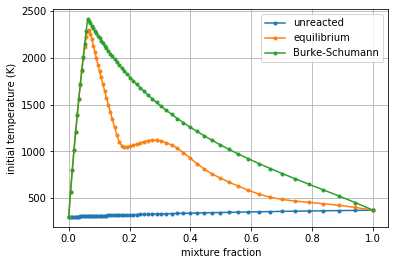

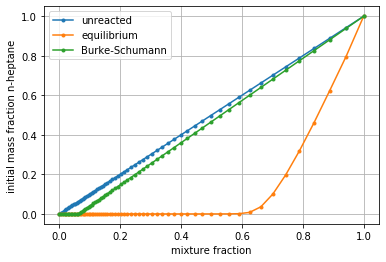

In [6]:
for key in ['unreacted', 'equilibrium', 'Burke-Schumann']:
    flamelet = flamelets[key]
    plt.plot(flamelet.mixfrac_grid, flamelet.initial_temperature, '.-', label=key)
plt.legend()
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('initial temperature (K)')
plt.show()

for key in ['unreacted', 'equilibrium', 'Burke-Schumann']:
    flamelet = flamelets[key]
    plt.plot(flamelet.mixfrac_grid, flamelet.initial_mass_fraction('NXC7H16'), '.-', label=key)
plt.legend()
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('initial mass fraction n-heptane')
plt.show()

## The Grid

Carefully note in the above plots how the distribution of the grid points is not uniform. When specifying only the number of grid points, a clustered grid that focuses grid points near the stoichiometric mixture fraction is made.

Below we specify the `grid_type` to be "uniform" instead of "clustered" (the default value) and build another equilibrium flamelet. Zooming in near the stoichiometric point with the highest curvature in the temperature shows how the uniform grid misses this curvature. In rare cases when dynamics in very rich mixtures are relevant, a uniform grid ends up being the most efficient option, but most often the clustered grid is far superior.

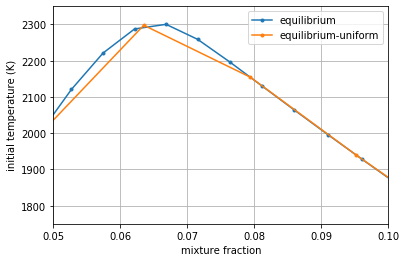

In [207]:
flamelets['equilibrium-uniform'] = Flamelet(mech_spec=mech, 
                                            initial_condition='equilibrium',
                                            oxy_stream=air,fuel_stream=fuel,
                                            grid_points=64,
                                            grid_type='uniform')

for key in ['equilibrium', 'equilibrium-uniform']:
    flamelet = flamelets[key]
    plt.plot(flamelet.mixfrac_grid, flamelet.initial_temperature, '.-', label=key)
plt.legend()
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('initial temperature (K)')
plt.xlim([0.05, 0.1])
plt.ylim([1750, 2350])
plt.show()

## Getting a Steady Flamelet at Finite Dissipation

In the `Flamelet` instances above, we avoided specifying the scalar dissipation rate, which leads to it being zero.
To incorporate molecular mixing, the dissipation rate can be specified a few ways:
- `max_dissipation_rate` or `stoich_dissipation_rate`, along with `dissipation_rate_form` as either "constant" or "Peters" (the default) to use a specified functional form of the dissipation rate
- `dissipation_rate` to directly provide an array of values

In [13]:
flamelets['eq-Peters-st10Hz'] = Flamelet(FlameletSpec(mech_spec=mech, 
                                                      initial_condition='equilibrium',
                                                      oxy_stream=air,
                                                      fuel_stream=fuel,
                                                      grid_points=64,
                                                      stoich_dissipation_rate=10.0))
flamelets['eq-Peters-max10Hz'] = Flamelet(FlameletSpec(mech_spec=mech, 
                                                       initial_condition='equilibrium',
                                                       oxy_stream=air,
                                                       fuel_stream=fuel,
                                                       grid_points=64,
                                                       max_dissipation_rate=10.0))
flamelets['eq-constant-10Hz'] = Flamelet(FlameletSpec(mech_spec=mech, 
                                                      initial_condition='equilibrium',
                                                      oxy_stream=air,
                                                      fuel_stream=fuel,
                                                      grid_points=64,
                                                      stoich_dissipation_rate=10.0,
                                                      dissipation_rate_form='constant'))
flamelets['eq-constant-10Hz-array'] = Flamelet(FlameletSpec(mech_spec=mech, 
                                                            initial_condition='equilibrium',
                                                            oxy_stream=air,
                                                            fuel_stream=fuel,
                                                            grid_points=64,
                                                            dissipation_rate=10.0 * np.ones(64)))

### The `compute_steady_state()` Method

Now that we have flamelets with dissipation, the `compute_steady_state()` method can be used to compute the steady temperature and mass fraction profiles that represent the balance between molecular mixing and combustion chemistry. After calling this method, the `current_*` properties for temperature, mass fractions, etc. of the flamelet can be accessed.

In the following plots (the second simply zooms in on the first), you can see the effect of dissipation, mostly to smooth out the equilibrium profile as chemistry is balanced by mixing.

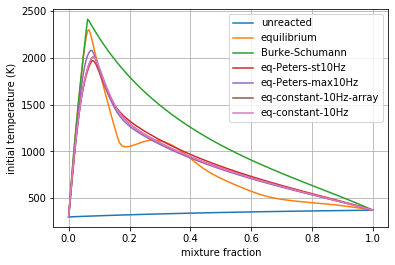

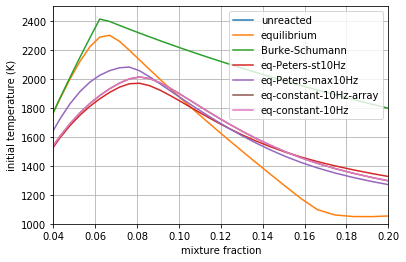

In [20]:
for key in ['eq-Peters-st10Hz', 'eq-Peters-max10Hz', 'eq-constant-10Hz-array', 'eq-constant-10Hz']:
    flamelets[key].compute_steady_state()

    
for key in ['unreacted', 'equilibrium', 'Burke-Schumann'] + \
           ['eq-Peters-st10Hz', 'eq-Peters-max10Hz', 'eq-constant-10Hz-array', 'eq-constant-10Hz']:
    flamelet = flamelets[key]
    plt.plot(flamelet.mixfrac_grid, flamelet.current_temperature, label=key)
plt.legend()
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('initial temperature (K)')
plt.show()

for key in ['unreacted', 'equilibrium', 'Burke-Schumann'] + \
           ['eq-Peters-st10Hz', 'eq-Peters-max10Hz', 'eq-constant-10Hz-array', 'eq-constant-10Hz']:
    flamelet = flamelets[key]
    plt.plot(flamelet.mixfrac_grid, flamelet.current_temperature, label=key)
plt.legend()
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('initial temperature (K)')
plt.xlim([0.04, 0.2])
plt.ylim([1000, 2500])
plt.show()

## Transient Extinction

Now we're going to solve the transient flamelet equations to look in detail at strain-induced extinction of a flamelet initially at chemical equilibrium. The plots below show the transition from the equilibrium profiles to the extinguished state.

In [208]:
flamelet = Flamelet(FlameletSpec(mech_spec=mech, 
                                 initial_condition='equilibrium',
                                 oxy_stream=air,
                                 fuel_stream=fuel,
                                 grid_points=64,
                                 stoich_dissipation_rate=1.e3))

output = flamelet.integrate_to_steady(write_log=True, first_time_step=1e-9)


 2021-02-09 11:35 : Spitfire running case with method: Kennedy/Carpenter ESDIRK64

|number of  | simulation | time step  | diff. eqn. | total cpu  | cput per |
|time steps | time (s)   | size (s)   | |residual| | time (s)   | step (ms)|
---------------------------------------------------------------------------|
| 100       | 9.26e-07   | 2.95e-08   | 2.60e+05   | 1.69e+00   | 1.69e+01 |
| 200       | 9.78e-06   | 1.49e-07   | 4.83e+04   | 4.10e+00   | 2.05e+01 |
| 300       | 3.22e-05   | 5.43e-07   | 1.35e+04   | 6.40e+00   | 2.13e+01 |
| 400       | 1.58e-04   | 2.70e-06   | 1.67e+02   | 8.88e+00   | 2.22e+01 |

Integration successfully completed!

Statistics:
- number of time steps : 446
- final simulation time: 0.000587475337460484
- smallest time step   : 1e-09
- average time step    : 1.3172092768172287e-06
- largest time step    : 3.73510924976309e-05

  CPU time
- total    (s) : 1.014457e+01
- per step (ms): 2.274567e+01

  Nonlinear iterations
- total   : 11480
- per step: 2

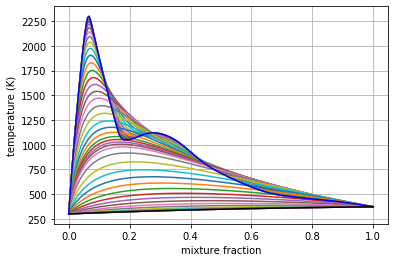

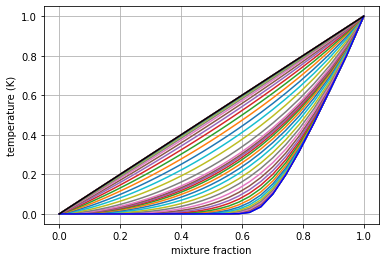

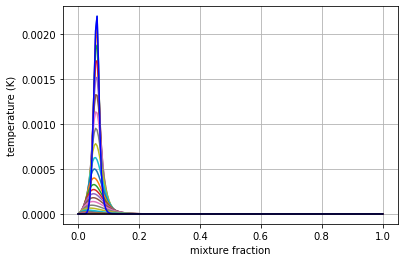

In [210]:
plt.plot(output.mixture_fraction_values, output['temperature'].T[:, ::10])
plt.plot(output.mixture_fraction_values, output['temperature'].T[:, 0], 'b-')
plt.plot(output.mixture_fraction_values, output['temperature'].T[:, -1], 'k-')
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('temperature (K)')
plt.show()

plt.plot(output.mixture_fraction_values, output['mass fraction NXC7H16'].T[:, ::10])
plt.plot(output.mixture_fraction_values, output['mass fraction NXC7H16'].T[:, 0], 'b-')
plt.plot(output.mixture_fraction_values, output['mass fraction NXC7H16'].T[:, -1], 'k-')
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('temperature (K)')
plt.show()


plt.plot(output.mixture_fraction_values, output['mass fraction OH'].T[:, ::10])
plt.plot(output.mixture_fraction_values, output['mass fraction OH'].T[:, 0], 'b-')
plt.plot(output.mixture_fraction_values, output['mass fraction OH'].T[:, -1], 'k-')
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('temperature (K)')
plt.show()


## Parameter Continuation, Transient Extinction, and Progress Variable Tabulation

Now we combine the main ideas from this notebook to generate a steady and transient extinction trajectory for our n-heptane/air mixture. We'll do parameter continuation in the stoichiometric dissipation rate until we get near extinction, and then we'll jump the dissipation rate and capture the transient extinction event. Building atop this, we'll transform the steady and transient libraries into a single library built atop the mixture fraction and the stoichiometric value of a progress variable chosen as the mass fraction of CO2. This requires the source term of CO2, which we compute with Cantera, leveraging Spitfire's `get_ct_solution_array()` method.

Below the `slfm_lib` variable is made one value of $\chi_{\rm st}$ at a time. As with standard SLFM, the extinction dynamics are not included in the table.

In [184]:
chi_values = np.logspace(-3, 2, 17)
fs0 = FlameletSpec(mech_spec=mech, 
                   initial_condition='equilibrium',
                   oxy_stream=air,
                   fuel_stream=fuel,
                   grid_points=64,
                   stoich_dissipation_rate=chi_values[0])
z_values = Flamelet(fs0).mixfrac_grid

slfm_lib = Library(Dimension('mixture_fraction', z_values),
                   Dimension('dissipation_rate_stoich', chi_values))
slfm_lib['temperature'] = slfm_lib.get_empty_dataset()
slfm_lib['pressure'] = slfm_lib.get_empty_dataset()
for s in mech.species_names:
    slfm_lib[f'mass fraction {s}'] = slfm_lib.get_empty_dataset()
slfm_lib.extra_attributes['mech_spec'] = mech

print(f'{"chi_st (Hz)":>12} | {"T_max (K)":<12}')
print('-' * 27)

for idx, chi_st in enumerate(chi_values):
    
    fs = fs0 if idx == 0 else FlameletSpec(library_slice=steady_lib, stoich_dissipation_rate=chi_st)
    f = Flamelet(fs)
    steady_lib = f.compute_steady_state()
    
    print(f'{chi_st:>12.1e} | {steady_lib["temperature"].max():<12.1f}')
    
    for prop in steady_lib.props:
        slfm_lib[prop][:, idx] = steady_lib[prop]
print('-' * 27)

fse = FlameletSpec(library_slice=slfm_lib[:, -1], stoich_dissipation_rate=chi_values[-1] * 10.)
fext = Flamelet(fse)

ext_lib = fext.integrate_to_steady(write_log=True)

 chi_st (Hz) | T_max (K)   
---------------------------
     1.0e-03 | 2237.9      
     2.1e-03 | 2233.3      
     4.2e-03 | 2225.9      
     8.7e-03 | 2215.1      
     1.8e-02 | 2200.7      
     3.7e-02 | 2182.8      
     7.5e-02 | 2161.6      
     1.5e-01 | 2138.5      
     3.2e-01 | 2117.9      
     6.5e-01 | 2092.6      
     1.3e+00 | 2069.1      
     2.7e+00 | 2038.9      
     5.6e+00 | 2001.7      
     1.2e+01 | 1961.1      
     2.4e+01 | 1910.2      
     4.9e+01 | 1840.0      
     1.0e+02 | 1729.9      
---------------------------

 2021-02-08 22:53 : Spitfire running case with method: Kennedy/Carpenter ESDIRK64

|number of  | simulation | time step  | diff. eqn. | total cpu  | cput per |
|time steps | time (s)   | size (s)   | |residual| | time (s)   | step (ms)|
---------------------------------------------------------------------------|
| 100       | 9.69e-06   | 1.28e-07   | 4.25e+04   | 2.92e+00   | 2.92e+01 |
| 200       | 2.29e-05   | 4.89e-07   | 1.95e+04

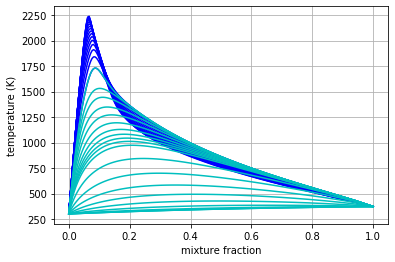

In [185]:
plt.plot(slfm_lib.mixture_fraction_values, slfm_lib['temperature'], 'b')
plt.plot(ext_lib.mixture_fraction_values, ext_lib['temperature'].T[:, ::18], 'c')
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('temperature (K)')
plt.show()

To combine the libraries and prepare for progress variable identification, we first simply map onto $\chi_{\rm st}(1+t)$, where $t$ is the extinction time, for the second dimension to ensure uniqueness.

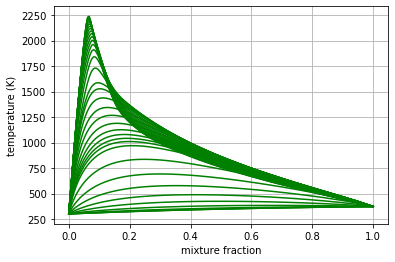

In [192]:
t_step = 18  # just to reduce the data size a little
t_values_step = ext_lib.time_values[1::t_step]
chi_opt = np.hstack((chi_values, chi_values[-1] *(1. + t_values_step)))

combined_lib = Library(Dimension('mixture_fraction', z_values), Dimension('chi_opt', chi_opt))

for prop in slfm_lib.props:
    combined_lib[prop] = combined_lib.get_empty_dataset()
    combined_lib[prop][:, :chi_values.size] = slfm_lib[prop][:, :chi_values.size]
    combined_lib[prop][:, chi_values.size:] = ext_lib[prop][1::t_step, :].T

plt.plot(combined_lib.mixture_fraction_values, combined_lib['temperature'], 'g')
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('temperature (K)')
plt.show()

Now we build one-dimensional interpolation to compute stoichiometric values of every tabulated property over the combined second dimension. These will be used to define a progress variable.

In [188]:
from scipy.interpolate import interp1d

stoich_values = Library(Dimension('chi_opt', chi_opt))
z_st = mech.stoich_mixture_fraction(fuel, air)

for prop in combined_lib.props:
    stoich_values[prop] = stoich_values.get_empty_dataset()
    stoich_values[prop] = interp1d(combined_lib.mixture_fraction_values, 
                                   combined_lib[prop],
                                   axis=0)(z_st)

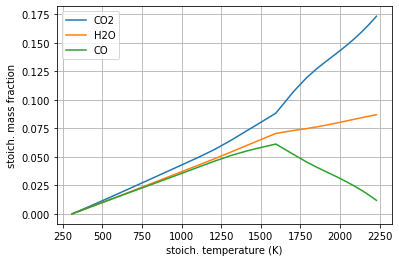

In [189]:
for s in ['CO2', 'H2O', 'CO']:
    plt.plot(stoich_values[f'temperature'], stoich_values[f'mass fraction {s}'], label=s)
plt.grid()
plt.xlabel('stoich. temperature (K)')
plt.ylabel('stoich. mass fraction')
plt.legend()
plt.show()

The above shows that CO2 and H2O, unlike CO, are admissible progress variables as they vary monotonically from the high-temperature equilibrium state to the extinguished state. Linear combinations of mass fractions could be employed, but here we'll keep things simple and just use CO2.

In [194]:
Y_CO2_st = stoich_values[f'mass fraction CO2']
Y_CO2_st_scaled = (Y_CO2_st - Y_CO2_st.min()) / (Y_CO2_st.max() - Y_CO2_st.min())

progvar_lib = Library(Dimension('mixture_fraction', z_values),
                      Dimension('scaled_st_Y_CO2', Y_CO2_st_scaled))

for prop in combined_lib.props:
    progvar_lib[prop] = combined_lib[prop]

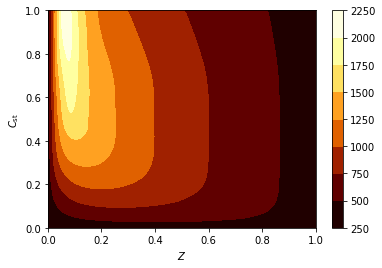

In [195]:
plt.contourf(progvar_lib.mixture_fraction_grid,
             progvar_lib.scaled_st_Y_CO2_grid,
             progvar_lib['temperature'],
             cmap='afmhot')
plt.xlabel('$Z$')
plt.ylabel('$C_{\\rm st}$')
plt.colorbar()
plt.show()

A requirement for the FPV tabulation is to tabulate the source term of the progress variable. While Spitfire computes chemical source terms and much more in order to solve flamelet problems, the most convenient way of getting reaction rates and other thermochemical properties is to use Cantera. For this, `get_ct_solution_array`, which takes a mechanism and library, can be used to obtain a `SolutionArray` object from Cantera which acts like a single thermochemical state but loops over a large number behind the scenes. So we can simply call `net_production_rates` to get the molar species production rates, and then reshape them into the library.

In [198]:
ct_array, lib_shape = get_ct_solution_array(mech, progvar_lib)

co2_idx = mech.species_index('CO2')
co2_mw = mech.molecular_weight('CO2')

progvar_lib['prod rate CO2'] = co2_mw * ct_array.net_production_rates[:, co2_idx].reshape(lib_shape)
progvar_lib['C source'] = progvar_lib['prod rate CO2'] / (Y_CO2_st.max() - Y_CO2_st.min())

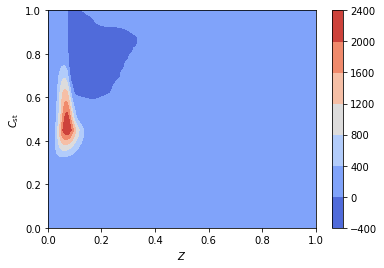

In [202]:
plt.contourf(progvar_lib.mixture_fraction_grid,
             progvar_lib.scaled_st_Y_CO2_grid,
             progvar_lib['C source'],
             cmap='coolwarm')
plt.colorbar()
plt.xlabel('$Z$')
plt.ylabel('$C_{\\rm st}$')
plt.show()

## Conclusions

In this demonstration we've covered the basics of specifying a flamelet model with initialization options, dissipation rate forms, and grid types. Following this we solved the steady and transient flamelet equations, ultimately performing parameter continuation to build an SLFM library, and combined with a transient extinction calculation to build an FPV library.